In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt, exp, log, pi

### Dispertion analysis

In the simulation we set the initial STD of the gaussian profile. 

$$ \exp \left(- \frac{(x -x_i)^2 }{2\sigma ^2 } \right) $$

The analytical law for pure diffusion of an initial dirac function is

$$ c(x,t)=\frac{c_0}{\sqrt{4\pi D t}}\exp{\left(-\frac{(x-x_i)^2}{4Dt}\right)}$$

Thus

$$ \sigma ^2 = 2 D t_i$$

with $t_i$ the initial time corresponding to t=0 in the simulaiton.

$$t_i =  \frac{\sigma ^2}{2 D }  $$

We have then

$$ 1=c_0/\sqrt{(4 \pi D t_i)} $$

$$ c_0=\sqrt{2 \pi \sigma ^2 } $$

The solution over time is 


$$ c(x,t)=\frac{\sqrt{2 \pi \sigma ^2 } }{\sqrt{4\pi D t}}\exp{\left(-\frac{(x-x_i)^2}{4Dt}\right)}$$

$$ c(x,t)=\frac{\sigma  }{\sqrt{2 D t}}\exp{\left(-\frac{(x-x_i)^2}{4Dt}\right)}$$

The unknowm is $D$, the apparent diffusion coefficient.



## Method using the FWHM 

At any time we have the STD of the gaussian profile : 

$$ \sigma_n ^2 = 2 D t_n$$

Therefor the apparent diffusion coefficient can be estimated as the slope og the linear fit of the function $f(tn)=\sigma_n^2/2$.

Where $\sigma_n$ is estimated from the Full Width at Half the Maximum, 

$$\sigma_n = \frac{FWHM}{\sqrt{8\ln 2}}   $$

In [2]:
# compute FWHM using the roots of a fitted spline
from scipy.interpolate import UnivariateSpline

def FWHM(X,Y):
    spline = UnivariateSpline(X, Y-np.max(Y)/2, s=0)
    roots=spline.roots() # find the roots
    if len(roots)==1 :
        #print('Warning : there is only one root to the spline, we return 2*dist(max)')
        fwhm=2*abs(X[np.argmax(Y)]-roots[0])
    elif len(roots)==2 :
        fwhm=abs(roots[1]-roots[0])
    else :
        #print('Error : unexpected number of roots of the fitted spline')
        fwhm=X.max()-X.min()
    
    return fwhm


In [3]:
from sklearn import linear_model

# With only one linear fit 
def estimate_diff_FWHM_fit(spanTime,spanFWHM) :
    spanSigma=spanFWHM/(2*sqrt(2*log(2)))
    
    X = np.array(spanTime).reshape((-1, 1))
    y = np.array(spanSigma**2)/2

    regressor = linear_model.LinearRegression()
    regressor.fit(X, y)
    a = regressor.coef_[0]
    b = regressor.intercept_
    plt.figure()
    plt.plot(spanTime,spanSigma**2/2,'*')
    plt.plot(spanTime,a*(spanTime-(-b/a)))
    plt.xlabel('time (s)')
    plt.ylabel(u'$\sigma^2/2$')
    plt.title('linear fit for the FWHM method')

    return regressor.coef_[0]

# with the slope, can vary with time
def estimate_diff_FWHM_slope(spanTime,spanFWHM) :
    spanSigma=spanFWHM/(2*sqrt(2*log(2)))
    y = np.array(spanSigma**2)/2

    slope=np.diff(y)/np.diff(spanTime)
    
    plt.plot(spanTime[0:-1],slope,'*')
    plt.xlabel('time (s)')
    plt.ylabel('$Deff$')
    plt.title('Slope of \sigma^2/2 vs t')
    
    return slope

## Method using gaussian fit

We look for the best fit of the form 


$$ c(x,t)=\frac{\sigma  }{\sqrt{2 D t}}\exp{\left(-\frac{(x-x_i)^2}{4Dt}\right)}$$

with $D$ being the only unknown

In [4]:
def gaussian (x,t,s,D,L,xi) :
    return s/sqrt(2*D*t)*np.exp(-(x-xi)**2/(4*D*t))

Text(0, 0.5, 'c')

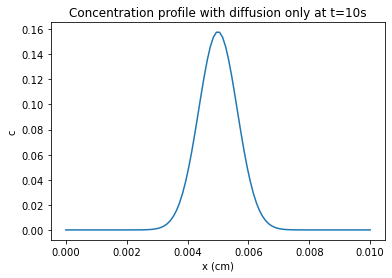

In [5]:
x=np.linspace(0,100e-4,100)
plt.plot(x,gaussian (np.array(x),10,1e-4,2e-8,100e-4,50e-4))
plt.title('Concentration profile with diffusion only at t=10s')
plt.xlabel('x (cm)')
plt.ylabel('c')

In [6]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

def estimate_diff_fit(spanC,spanX,t,sigma,L) :
    
    
    def fitfunction(x,D,xi) :
        tini=sigma**2/(2*D)
        return  gaussian (spanX,t+tini,sigma,D,L,xi)
    
    popt, pcov = curve_fit(fitfunction, spanX,spanC,bounds=([1e-9,0],[1e-4,L]))
    
    fit = fitfunction(spanX,*popt)
    
    err=mean_squared_error(spanC, fit) 
    
    D=popt[0]
    xi=popt[1]
        
    return D,xi, err

In [7]:
L=100e-4
Dtest=5.489e-8
xtest=np.linspace(0,L,100)
ttest=10
sigma=1e-4
# create a profile (that would normally come from the simulation)
profile_test=gaussian(xtest,ttest+sigma**2/(2*Dtest),sigma,Dtest,L,L)
#estimate the D coeff with fit
Dest,xi, err = estimate_diff_fit(profile_test,xtest,ttest,sigma,L)

print('Estimation of D from fit : %.2e'%Dest)
print('Actual value of D : %.2e'%Dtest)
print('Error (pc): %.2e'%((Dest-Dtest)/Dtest*100))

Estimation of D from fit : 5.49e-08
Actual value of D : 5.49e-08
Error (pc): 2.09e-05


# Analysis of diffusion only

In [46]:
job='diffusion-D0 '
rep='/home/alexandra/Documents/Python/sleep/sleep/output/'+job+'/'
file='profiles/concentration.txt'

Data=np.loadtxt(rep+file,delimiter=',')

x=Data[0,1:]
t=Data[1:,0]

concentration=Data[1:,1:]

pressure=np.loadtxt(rep+'profiles/pressure.txt',delimiter=',')[1:,1:]

velocity=np.loadtxt(rep+'profiles/velocity.txt',delimiter=',')[1:,1:]

OSError: /home/alexandra/Documents/Python/sleep/sleep/output/diffusion-D0 /profiles/concentration.txt not found.

#### Simulation parameters

In [47]:
import re
scinot = re.compile('[+\-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+)')

# Should get D, L, rho, nu, f, amp, Rpvs, Rv0,sigma and x0 from the log file
file='PVS_info.log'


with open(rep+file) as fl:
    line = fl.readline()
    while line:
        line = fl.readline()
        if line[0:6] == 'Vessel' :
            Rv0=float(re.findall(scinot, line)[0])
        elif line[0:6] == 'PVS ra' :
            Rpvs=float(re.findall(scinot, line)[0])  
        elif line[0:6] == 'PVS le' :
            L=float(re.findall(scinot, line)[0])   
        elif line[0:6] == 'densit' :
            rho=float(re.findall(scinot, line)[0])
        elif line[0:6] == 'dynami' :
            mu=float(re.findall(scinot, line)[0])   
        elif line[0:6] == 'Free d' :
            D=float(re.findall(scinot, line)[0]) 
        elif line[0:6] == 'STD of' :
            sigma=float(re.findall(scinot, line)[0])  
        elif line[0:6] == 'Initia' :
            xi=float(re.findall(scinot, line)[0])
        elif line[0:6] == 'fi (Hz':
            f=float(re.findall(scinot, line)[0]) # Check if it works for several frequencies
        elif line[0:6] == 'ai (di':
            amp=float(re.findall(scinot, line)[0])*100 # Check if it works for several frequencies
        elif line[0:6] == 'time s':
            time_step=float(re.findall(scinot, line)[0])
        elif line[0:6] == 'cell s':
            cell_size=float(re.findall(scinot, line)[0])            
            
print('Rv : %.2f um'%(Rv0*1e4))
print('Rpvs : %.2f um'%(Rpvs*1e4))
print('Length : %.2f um'%(L*1e4))

print('\nDensity : %.2e g/cm3'%rho)
print('Viscosity : %.2e dyn s /cm2'%mu)
nu=mu/rho

print('\nDiffusion coefficient: %.2e cm2/s'%(D))      
print('STD gausian : %.2e cm'%(sigma))
print('center gaussian: %.2e um'%(xi*1e4))

print('\nfrequency : %.2e Hz'%f)
print('\namplitude : %.2e pc'%amp)

print('spatial resolution : %.2e um'%(cell_size*1e4))
print('temporal resolution : %.2e s'%time_step)

FileNotFoundError: [Errno 2] No such file or directory: '/home/alexandra/Documents/Python/sleep/sleep/output/diffusion-D0\xa0/PVS_info.log'

In [48]:
iperiodic=list(np.arange(0,len(t),10))

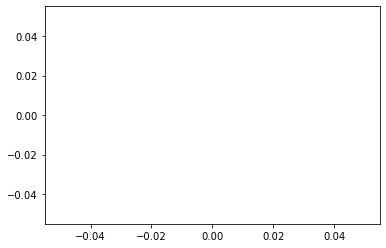

In [49]:
span_FWHM=[]
for c in concentration :
    span_FWHM.append(FWHM(x,c))
    plt.plot(x,c)
    
span_FWHM=np.array(span_FWHM) 
#plt.xlim([35e-4,65e-4])

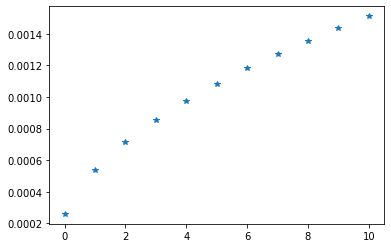

In [13]:
plt.plot(t[iperiodic],span_FWHM[iperiodic],'*')

### Estimation of D from FWHM

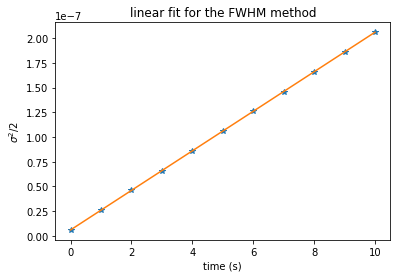

In [14]:
Dest0=estimate_diff_FWHM_fit(t[iperiodic],span_FWHM[iperiodic])
plt.xlabel('time (s)')
plt.ylabel(u'$\sigma^2/2$')
plt.title('linear fit for the FWHM method')

plt.savefig('/home/alexandra/Documents/Articles/Sleep/Images/FWHM_diff.svg')
plt.savefig('/home/alexandra/Documents/Articles/Sleep/Images/FWHM_diff.png')

In [15]:
print('Estimation of D from FWHM : %.2e'%Dest0)
print('Error (pc): %.2e'%(abs(Dest0-D)/D*100))

Estimation of D from FWHM : 2.00e-08
Error (pc): 1.12e-02


We recover the diffusion coefficient from the simulation.

### Estimation of D from fit

Text(0.5, 1.0, 'Estimate of D with fit method')

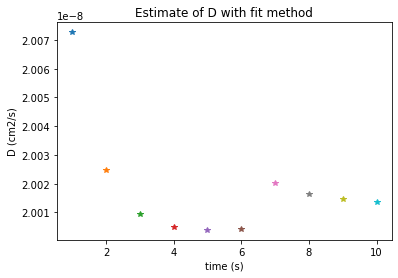

In [16]:
# we take the time at last period
spanDest=[]
spanXi=[]
for itime in iperiodic[1:] : 
    #print('\nEstimate at time %f s'%t[itime])

    Dest,Xi, err = estimate_diff_fit(concentration[itime],x,t[itime],1e-4,100e-4)

    #print('Estimation of D from fit : %.2e'%Dest)
    #print('Fit error : %.2e'%err)
    
    spanDest.append(Dest)
    spanXi.append(Xi)
    plt.plot(t[itime],Dest,'*')
    
plt.xlabel('time (s)')
plt.ylabel('D (cm2/s)')
plt.title('Estimate of D with fit method')

In [17]:
print('Estimation of D from fit : %.2e'%spanDest[-1])
print('Error (pc): %.2e'%(abs(spanDest[-1]-D)/D*100))

Estimation of D from fit : 2.00e-08
Error (pc): 6.89e-02


Both methods give good results. The fit method needs longer time as it is converging.

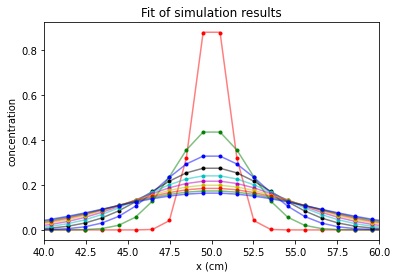

In [18]:
color='rgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmy'
icol=0
for i in range(0,len(spanDest)) :
    plt.plot(x*1e4,concentration[iperiodic[i]],'.',color=color[icol])
    plt.plot(x*1e4,gaussian(np.array(x),t[iperiodic[i]]+sigma**2/(2*spanDest[i]),sigma,spanDest[i],L,spanXi[i]),color=color[icol],alpha=0.5)
    icol+=1
plt.xlabel('x (cm)')
plt.ylabel('concentration')
plt.title('Fit of simulation results')
plt.xlim([40,60])

plt.savefig('/home/alexandra/Documents/Articles/Sleep/Images/fit_diff.svg')
plt.savefig('/home/alexandra/Documents/Articles/Sleep/Images/fit_diff.png')

In [19]:
h_=2e-4
D_=2e-8
L_=200e-4
f_=0.003


print('diffusion time constrain',10*h_**2/L_**2*1000)
print('oscillation time constrain',3*D_/f_/L_**2*20)


np.sqrt(3*300*1e-7)*1e4

diffusion time constrain 0.9999999999999998
oscillation time constrain 1.0


94.86832980505137

# Analysis of 2D pulsating simulation

In [8]:
Database=[]
datalabel=['job', 'Rv0', 'Rpvs', 'L', 'DX', 'dt', 'rho', 'mu', 'D', 'sigma', 'xi', 'f', 'umax','pmax', 'Pe', 'Re', 'Wo', 'Fo' , 'A', 'beta', 'dPdx', 'T','nPeriod' , 'tend', 'FWHMend','DestFWHM', 'Destfit', 'RFWHM', 'Rfit', 'amp','thetaa', 'tau']

In [15]:
### Load data
# set a condition on time analysis to stay in 1D in the PVS
conditiontime=True
conditionalpha=False

#### Simulation results

job='global-600pm-3mHz-D0'
rep='/home/alexandra/Documents/Python/sleep/sleep/output/'+job+'/'

rep='/home/alexandra/Documents/Python/sleep/sleep/output/compcon/'

rep='/home/alexandra/Documents/Python/sleep/sleep/output/taylordisp/'

rep='/home/alexandra/Documents/Python/sleep/sleep/output/taylorunsteady/'

rep='/home/alexandra/Documents/Python/sleep/sleep/output/taylorunsteady_h2f1/'

rep='/home/alexandra/Documents/Python/sleep/sleep/output/PVS_h2f1/'

rep='/home/alexandra/Documents/Python/sleep/sleep/output/lowepsilon2-100pm-2000mHz-plane/'

rep='/home/alexandra/Documents/Python/sleep/sleep/output/lowepsilon2-100pm-2000mHz-uanalytical/'



#### In vivo study

mouse='WT08'
study='03'
D=2e-7
stage='NREM'
bandname='VLF'
point='_mean'
point='_pt'+str(0) 
job=mouse+'-'+study+'-'+stage+point

job='WT08-03-REM-VLF_pt7'

rep='/home/alexandra/Documents/Python/sleep/sleep/output/'+job+'/'

Rv : 10.85 um
Rpvs : 16.79 um
Length : 200.00 um

Density : 1.00e+00 g/cm3
Viscosity : 7.00e-03 dyn s /cm2

Diffusion coefficient: 2.00e-07 cm2/s
STD gausian : 1.00e-04 cm
center gaussian: 1.00e+02 um

frequency : 1.85e-01 Hz

amplitude : 7.81e+00 pc
spatial resolution : 1.05e+00 um
temporal resolution : 8.44e-02 s
Umax : 18.224 um/s
Pmax : 0.461 pa 

max Reynolds number : 2e-04
max Peclet number : 5e+00
Womersley number : 8e-03
Fourier number : 3e-02
final time simulation : 1.62e+01 s
output period : 8.44e-02 s
analysis period : 5.40e+00 s
spatial resotion : 2.02e+00 um

final time analysis : 1.62e+01 s
number of period analysed: 3
tau: 9.18e+00
theta a : 3.8e+00

Estimation of D from FWHM : 2.24e-07
Estimation of D from fit : 2.22e-07

Estimation of R from FWHM : 1.20e-01
Estimation of R from fit : 1.12e-01
Pe : 1.69e+00
Taylor disp theoretical : 1.36e-02


Text(0.5, 1.0, 'Fit of simulation results')

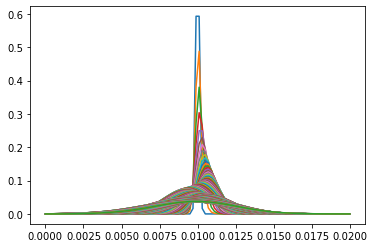

<Figure size 432x288 with 0 Axes>

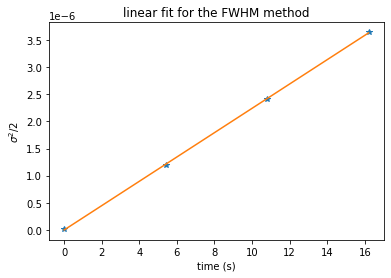

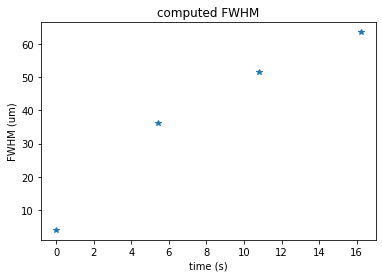

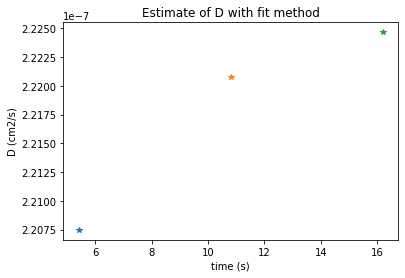

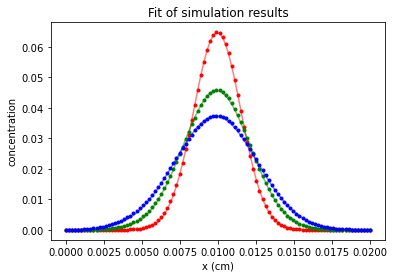

In [16]:
file='profiles/concentration.txt'

Data=np.loadtxt(rep+file,delimiter=',')


t=Data[1:,0]

concentration=Data[1:,1:]

pressure=np.loadtxt(rep+'profiles/pressure.txt',delimiter=',')[1:,1:]

velocity=np.loadtxt(rep+'profiles/velocity.txt',delimiter=',')[1:,1:]

#### Simulation parameters

import re
scinot = re.compile('[+\-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+)')

# Should get D, L, rho, nu, f, amp, Rpvs, Rv0,sigma and x0 from the log file
file='PVS_info.log'


with open(rep+file) as fl:
    line = fl.readline()
    while line:
        line = fl.readline()
        if line[0:6] == 'Vessel' :
            Rv0=float(re.findall(scinot, line)[0])
        elif line[0:6] == 'PVS ra' :
            Rpvs=float(re.findall(scinot, line)[0])  
        elif line[0:6] == 'PVS le' :
            L=float(re.findall(scinot, line)[0])   
        elif line[0:6] == 'densit' :
            rho=float(re.findall(scinot, line)[0])
        elif line[0:6] == 'dynami' :
            mu=float(re.findall(scinot, line)[0])   
        elif line[0:6] == 'Free d' :
            D=float(re.findall(scinot, line)[0]) 
        elif line[0:6] == 'STD of' :
            sigma=float(re.findall(scinot, line)[0])  
        elif line[0:6] == 'Initia' :
            xi=float(re.findall(scinot, line)[0])
        elif line[0:6] == 'fi (Hz':
            f=float(re.findall(scinot, line)[0]) # Check if it works for several frequencies
        elif line[0:6] == 'ai (di':
            amp=float(re.findall(scinot, line)[0])*100 # Check if it works for several frequencies
        elif line[0:6] == 'time s':
            time_step=float(re.findall(scinot, line)[0])
        elif line[0:6] == 'cell s':
            cell_size=float(re.findall(scinot, line)[0])    
            
print('Rv : %.2f um'%(Rv0*1e4))
print('Rpvs : %.2f um'%(Rpvs*1e4))
print('Length : %.2f um'%(L*1e4))

x=np.linspace(0,L,len(concentration[0,:]))

print('\nDensity : %.2e g/cm3'%rho)
print('Viscosity : %.2e dyn s /cm2'%mu)
nu=mu/rho

print('\nDiffusion coefficient: %.2e cm2/s'%(D))      
print('STD gausian : %.2e cm'%(sigma))
print('center gaussian: %.2e um'%(xi*1e4))

print('\nfrequency : %.2e Hz'%f)
print('\namplitude : %.2e pc'%amp)

print('spatial resolution : %.2e um'%(cell_size*1e4))
print('temporal resolution : %.2e s'%time_step)

### Compute dimensionless numbers

umax=np.max(abs(velocity))
pmax=np.max(abs(pressure))


w=2*pi*f
h=Rpvs-Rv0

Pe=h*umax/D
Re=rho*umax*h/mu
Wo=h*sqrt(w/mu)
Fo=D*t[-1]/xi**2

print('Umax : %.3f um/s'%(umax*1e4))
print('Pmax : %.3f pa \n'%(pmax/10))

print('max Reynolds number : %.0e'%Re)
print('max Peclet number : %.0e'%Pe)
print('Womersley number : %.0e'%Wo)
print('Fourier number : %.0e'%Fo)

dPdx=pmax/L
beta=D/mu
A=pi*(Rpvs**2-Rv0**2)


disptime=10*h**2/D


# We want to look to the results at each period (net flow 0)
dtoutput=t[1]-t[0]
tend=t[-1]



if (f>0):
    T=1/f
    ishift=0 #int(T/dtoutput*1/4)
else :
    T=t[-1]/10
    ishift=0
    
print('final time simulation : %.2e s'%tend)
print('output period : %.2e s'%dtoutput)

print('analysis period : %.2e s'%T)
DX=(x[1]-x[0])*1e4
print('spatial resotion : %.2e um'%(DX))


iperiodic=(np.arange(ishift,len(t),int(T/dtoutput)))

plt.figure()

span_FWHM=[]
for c in concentration :
    span_FWHM.append(FWHM(x,c))
    plt.plot(x,c)
    
span_FWHM=np.array(span_FWHM) 
#plt.xlim([35e-4,65e-4])

 
### Estimation of D from FWHM
plt.figure()
Dest=estimate_diff_FWHM_fit(t[iperiodic[::]],span_FWHM[iperiodic[::]])
DestFWHM=Dest

Ldiff=sqrt(Dest/t[iperiodic[-1]])

tmax=(L/2)**2/Dest/2

if conditiontime :
    #condition diffusion
    while t[iperiodic[-1]]>tmax : 
        print('* limitation of tend due to diffusion')
        it=np.where(t>=tmax)[0][0]
        ii=np.where(iperiodic>=it)[0][0]
        iperiodic=iperiodic[0:ii]
        
        plt.figure()
        Dest=estimate_diff_FWHM_fit(t[iperiodic[::]],span_FWHM[iperiodic[::]])
        DestFWHM=Dest
        tmax=(L/2)**2/Dest/2
        

thetaa=amp*L/(1+amp)/(L/2-2*np.sqrt(2*DestFWHM*t[iperiodic]))

if conditionalpha :
    #condition advection diffusion
    while thetaa[-1]>3 : 
        print('* limitation of tend due to theta a')
        ii=np.where(thetaa>=3)[0][0]
        iperiodic=iperiodic[0:ii]
        plt.figure()
        Dest=estimate_diff_FWHM_fit(t[iperiodic[::]],span_FWHM[iperiodic[::]])
        DestFWHM=Dest
        thetaa=amp*L/(1+amp)/(L/2-2*np.sqrt(2*DestFWHM*t[iperiodic]))

print('\nfinal time analysis : %.2e s'%t[iperiodic[-1]])



nPeriod=len(iperiodic)-1
print('number of period analysed: %i'%nPeriod)


if nPeriod==0 :
    # when you want to stop,
    raise HaltException('***The oscillatory analysis is not possible due to finite domain***')
    
plt.figure()
plt.plot(t[iperiodic],span_FWHM[iperiodic]*1e4,'*')
plt.xlabel('time (s)')
plt.ylabel('FWHM (um)')
plt.title('computed FWHM')

tau=t[iperiodic[-1]]/(h**2/D)
print('tau: %.2e'%tau)
print('theta a : %.1e'%thetaa[-1])

print('\nEstimation of D from FWHM : %.2e'%DestFWHM)



# When the apparent Diffusion coefficient is smaller with oscillation than diffusion alone at small time. What is going on? 

### Estimation of D from fit

# we take the time at last period
plt.figure()
spanDest=[]
spanXi=[]
for itime in iperiodic[1::] : 
    #print('\nEstimate at time %f s'%t[itime])

    Dest, Xi, err = estimate_diff_fit(concentration[itime],x,t[itime],sigma,L)

    #print('Estimation of D from fit : %.2e'%Dest)
    #print('Fit error : %.2e'%err)
    spanDest.append(Dest)
    spanXi.append(Xi)
    plt.plot(t[itime],Dest,'*')
    
plt.xlabel('time (s)')
plt.ylabel('D (cm2/s)')
plt.title('Estimate of D with fit method')

Destfit=spanDest[-1]
print('Estimation of D from fit : %.2e'%Destfit)


print('\nEstimation of R from FWHM : %.2e'%(DestFWHM/D-1))
print('Estimation of R from fit : %.2e'%(Destfit/D-1))


Pe=np.mean(np.abs(velocity)*(Rpvs-Rv0)/D)
print('Pe : %.2e'%(Pe))

print('Taylor disp theoretical : %.2e'%(Pe**2/210))

plt.figure()
color='rgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmy'
icol=0
for i in range(0,len(spanDest)) :
    plt.plot(x,concentration[iperiodic[i+1]],'.',color=color[icol])
    plt.plot(x,gaussian(np.array(x),t[iperiodic[i+1]]+sigma**2/(2*spanDest[i]),sigma,spanDest[i],L,spanXi[i]),color=color[icol],alpha=0.5)
    icol+=1
plt.xlabel('x (cm)')
plt.ylabel('concentration')
plt.title('Fit of simulation results')
#plt.xlim([L-50e-4,L])

### Update database

In [36]:
Database.append([job, Rv0, Rpvs, L, cell_size, time_step, rho, mu, D, sigma, xi, f, umax,pmax, Pe, Re, Wo, Fo , A, beta, dPdx, T,nPeriod , t[iperiodic[-1]], span_FWHM[iperiodic[-1]],DestFWHM, Destfit,DestFWHM/D, Destfit/D, amp, thetaa[-1],tau])

### Save database

In [ ]:
file_name='/home/alexandra/Documents/Python/sleep/sleep/output/'+mouse+'-'+study+'-'+stage+'-'+bandname+'.csv'

In [ ]:
labelstring=''
for d in datalabel:
    labelstring+=d+', '
    
labelstring=labelstring[0:-1]

In [ ]:
f = open(file_name, "w")
f.write(labelstring+'\n')
f.close()

In [ ]:
formatstring='%s'+' , %.6e'*31

In [ ]:
f = open(file_name, "a")
for d in Database :
    #print(formatstring%tuple(d))
    f.write(formatstring%tuple(d)+'\n')
f.close()

# Moments method

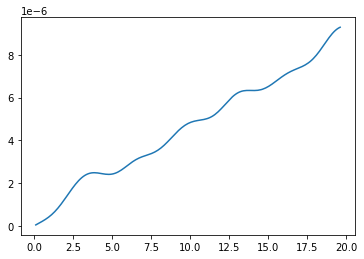

In [13]:
x0=100e-4
it=1
m0=np.zeros_like(t)
m2=np.zeros_like(t)
m1=np.zeros_like(t)
for it,time in enumerate(t):
    tointegrate=(x-x0)**0*concentration[it]
    m0[it]=np.trapz(tointegrate,x)
    tointegrate=(x-x0)*concentration[it]
    m1[it]=np.trapz(tointegrate,x)
    tointegrate=(x-x0)**2*concentration[it]
    m2[it]=np.trapz(tointegrate,x)

plt.plot(t,m2/m0)

t2d=t
m22d=m2/m0
m12d=m1/m0

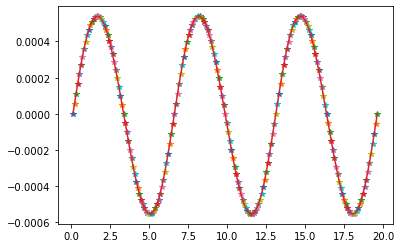

In [12]:
x0=100e-4
ix=np.where(x>=x0)[0][0]

vel2D=[]
for time,v in zip(t,velocity) :
    plt.plot(time,v[ix],'*')
    vel2D.append(v[ix])

t2d=t
plt.plot(t2d,vel2D)

# Analysis from 1D simulations

In [9]:
Database=[]
datalabel=['job', 'Rv0', 'Rpvs', 'L', 'DX', 'dt', 'rho', 'mu', 'D', 'sigma', 'xi', 'f', 'umax','pmax', 'Pe', 'Re', 'Wo', 'Fo' , 'A', 'beta', 'dPdx', 'T','nPeriod' , 'tend', 'FWHMend','DestFWHM', 'Destfit', 'RFWHM', 'Rfit', 'amp','thetaa', 'tau']

final time simulation : 1.50e+00 s
output period : 2.50e-02 s
analysis period : 5.00e-01 s
spatial resotion : 7.81e-01 um

final time analysis : 1.05e+00 s
number of period analysed: 2
tau: 1.05e+01
theta a : 2.2e-01

Estimation of D from FWHM : 4.26e-07
Estimation of D from fit : 4.62e-07

Estimation of R from FWHM : 3.26e+00
Estimation of R from fit : 3.62e+00


Text(0.5, 1.0, 'Fit of simulation results')

<Figure size 432x288 with 0 Axes>

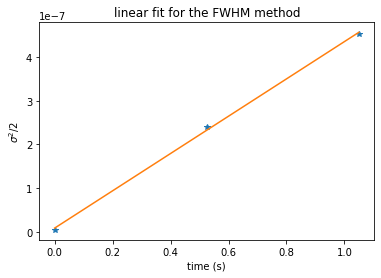

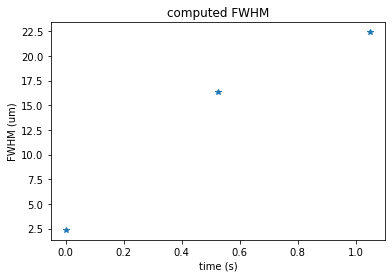

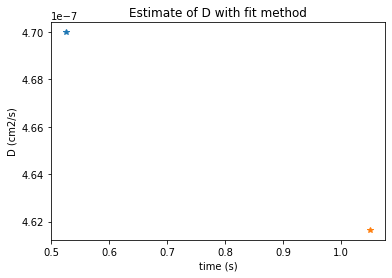

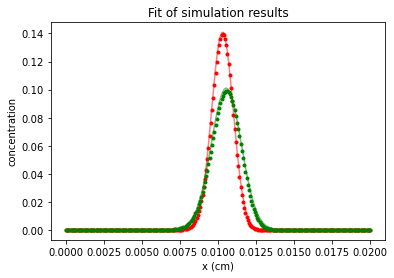

In [166]:
L=200e-4
tend=1.5
Nt=60
dtoutput=0.025
f=2000/1000
amp=100/1000
h=1e-4
D=1e-7
sigma=1e-4
Rv0=10e-4
mu=0.7e-3
rho=1
Rpvs=Rv0+h
# set a condition on time analysis to stay in 1D in the PVS
conditiontime=True
conditionalpha=True


t=np.linspace(0,Nt*dtoutput,Nt+1)
time_step='Na'

# Good comparison with 2D for the shuttle regime
#rep='/home/alexandra/Documents/Dune/dumux-pvs/build-cmake/test/lowepsilon1/100pm-50mHz_dirichlet/'

rep='/home/alexandra/Documents/Dune/dumux-pvs/build-cmake/test/lowepsilon2/100pm-2000mHz/'
Data=np.loadtxt(rep+'concentration_'+str(0)+'.csv',delimiter=',', skiprows=1)
Nx=len(Data[:,0])

x=np.linspace(0,L,Nx)
cell_size=x[1]-x[0]

spanindex=np.arange(0,Nt+1)


concentration=[]
flow1d=[]
thickness=[]

for ifile in spanindex:
    Data=np.loadtxt(rep+'concentration_'+str(ifile)+'.csv',delimiter=',', skiprows=1)
    concentration.append(Data[:,1]/100)
    Data=np.loadtxt(rep+'celldata_'+str(ifile)+'.csv',delimiter=',', skiprows=1)
    flow1d.append(Data[:,0]*1e6)
    Data=np.loadtxt(rep+'celldata_'+str(ifile)+'.csv',delimiter=',', skiprows=1)
    thickness.append(Data[:,2]*100)
    #plt.plot(x,concentration[-1])

    
# We want to look to the results at each period (net flow 0)
dtoutput=t[1]-t[0]
tend=t[-1]



if (f>0):
    T=1/f
    ishift=0 #int(T/dtoutput*1/4)
else :
    T=t[-1]/10
    ishift=0
    
print('final time simulation : %.2e s'%tend)
print('output period : %.2e s'%dtoutput)

print('analysis period : %.2e s'%T)
DX=(x[1]-x[0])*1e4
print('spatial resotion : %.2e um'%(DX))


iperiodic=(np.arange(ishift,len(t),int(T/dtoutput)+1))


span_FWHM=[]
for c in concentration :
    span_FWHM.append(FWHM(x,c))
    #plt.plot(x,c)
    
span_FWHM=np.array(span_FWHM) 
#plt.xlim([35e-4,65e-4])

 
### Estimation of D from FWHM
plt.figure()
Dest=estimate_diff_FWHM_fit(t[iperiodic[::]],span_FWHM[iperiodic[::]])
DestFWHM=Dest

Ldiff=sqrt(Dest/t[iperiodic[-1]])

tmax=(L/2)**2/Dest/2

if conditiontime :
    #condition diffusion
    while t[iperiodic[-1]]>tmax : 
        print('* limitation of tend due to diffusion')
        it=np.where(t>=tmax)[0][0]
        ii=np.where(iperiodic>=it)[0][0]
        iperiodic=iperiodic[0:ii]
        
        plt.figure()
        Dest=estimate_diff_FWHM_fit(t[iperiodic[::]],span_FWHM[iperiodic[::]])
        DestFWHM=Dest
        tmax=(L/2)**2/Dest/2
        

thetaa=amp*L/(1+amp)/(L/2-2*np.sqrt(2*DestFWHM*t[iperiodic]))

if conditionalpha :
    #condition advection diffusion
    while thetaa[-1]>3 : 
        print('* limitation of tend due to theta a')
        ii=np.where(thetaa>=3)[0][0]
        iperiodic=iperiodic[0:ii]
        plt.figure()
        Dest=estimate_diff_FWHM_fit(t[iperiodic[::]],span_FWHM[iperiodic[::]])
        DestFWHM=Dest
        thetaa=amp*L/(1+amp)/(L/2-2*np.sqrt(2*DestFWHM*t[iperiodic]))

print('\nfinal time analysis : %.2e s'%t[iperiodic[-1]])



nPeriod=len(iperiodic)-1
print('number of period analysed: %i'%nPeriod)


if nPeriod==0 :
    # when you want to stop,
    raise HaltException('***The oscillatory analysis is not possible due to finite domain***')
    
plt.figure()
plt.plot(t[iperiodic],span_FWHM[iperiodic]*1e4,'*')
plt.xlabel('time (s)')
plt.ylabel('FWHM (um)')
plt.title('computed FWHM')

tau=t[iperiodic[-1]]/(h**2/D)
print('tau: %.2e'%tau)
print('theta a : %.1e'%thetaa[-1])

print('\nEstimation of D from FWHM : %.2e'%DestFWHM)



#When the apparent Diffusion coefficient is smaller with oscillation than diffusion alone at small time. What is going on? 

### Estimation of D from fit

# we take the time at last period
plt.figure()
spanDest=[]
spanXi=[]
for itime in iperiodic[1::] : 
    #print('\nEstimate at time %f s'%t[itime])

    Dest, Xi, err = estimate_diff_fit(concentration[itime],x,t[itime],sigma,L)

    #print('Estimation of D from fit : %.2e'%Dest)
    #print('Fit error : %.2e'%err)
    spanDest.append(Dest)
    spanXi.append(Xi)
    plt.plot(t[itime],Dest,'*')
    
plt.xlabel('time (s)')
plt.ylabel('D (cm2/s)')
plt.title('Estimate of D with fit method')

Destfit=spanDest[-1]
print('Estimation of D from fit : %.2e'%Destfit)


print('\nEstimation of R from FWHM : %.2e'%(DestFWHM/D-1))
print('Estimation of R from fit : %.2e'%(Destfit/D-1))


#Pe=np.mean(velocity*(Rpvs-Rv0)/D)
#print('Pe : %.2e'%(Pe))

#print('Taylor disp theoretical : %.2e'%(Pe**2/210))

plt.figure()
color='rgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmyrgbkcmy'
icol=0
for i in range(0,len(spanDest)) :
    plt.plot(x,concentration[iperiodic[i+1]],'.',color=color[icol])
    plt.plot(x,gaussian(np.array(x),t[iperiodic[i+1]]+sigma**2/(2*spanDest[i]),sigma,spanDest[i],L,spanXi[i]),color=color[icol],alpha=0.5)
    icol+=1
plt.xlabel('x (cm)')
plt.ylabel('concentration')
plt.title('Fit of simulation results')
#plt.xlim([L-50e-4,L])

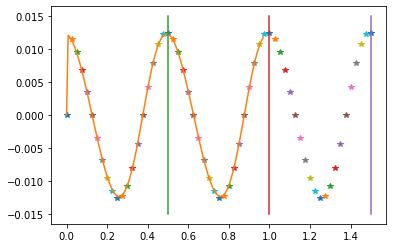

In [169]:
ix=np.where(x>=x0)[0][0]

for time,q,thick in zip(t,flow1d,thickness) :
    area=2*np.pi*(0.5*Rv0+0.5*Rpvs)*thick[0]
    plt.plot(time,q[ix]/area,'*')

plt.plot(t2d,vel2D)

plt.plot([0.5,0.5],[-0.015,0.015])
plt.plot([1,1],[-0.015,0.015])
plt.plot([1.5,1.5],[-0.015,0.015])

## Try with the moments method

(0.0, 1.5)

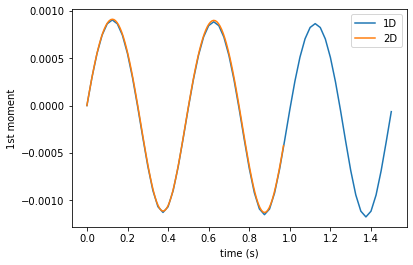

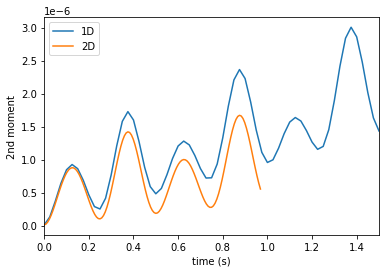

In [168]:
x0=100e-4

m0=np.zeros_like(t)
m1=np.zeros_like(t)
m2=np.zeros_like(t)
for it,time in enumerate(t):
    tointegrate=(x-x0)**0*concentration[it]
    m0[it]=np.trapz(tointegrate,x)
    tointegrate=(x-x0)**1*concentration[it]
    m1[it]=np.trapz(tointegrate,x)
    tointegrate=(x-x0)**2*concentration[it]
    m2[it]=np.trapz(tointegrate,x)

plt.plot(t,m1/m0, label='1D')
plt.plot(t2d,m12d, label='2D')

plt.ylabel('1st moment')
plt.xlabel('time (s)')
plt.legend()

plt.figure()

plt.plot(t,m2/m0, label='1D')
plt.plot(t2d,m22d, label='2D')
#plt.plot(t2db,m22db, label='2D cyl')
#t1d=t
#m21d=m2



plt.ylabel('2nd moment')
plt.xlabel('time (s)')
plt.legend()

m2period=[]
tperiod=np.array(range(0,int(tend/T)))*T
for tloc in tperiod:
    it=np.where(t>=tloc)[0][0]
    #plt.plot(t[it],m2[it]/m0[it],'*')
    m2period.append(m2[it]/m0[it])
    
plt.xlim([0,1.5])

In [148]:
len(t)

61

In [23]:
print('epsilon U',h**2/D*np.mean(np.abs(velocity))/L)
print('epsilon osc',h**2/D/T)


epsilon U 0.01970714442015156
epsilon osc 0.1


2.8

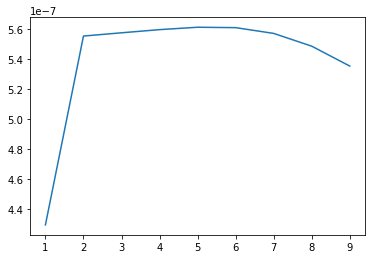

In [132]:
# compute the derivative

diffm2=np.diff(m2period)/np.diff(tperiod)
plt.plot(tperiod[1::],diffm2)

5.6/2

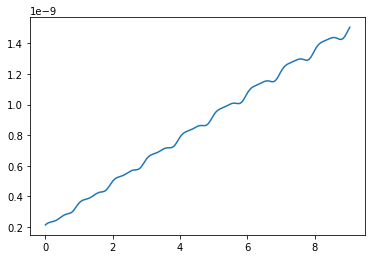

In [134]:
# compute the derivative

diffm2=np.diff(m2/m0)/np.diff(t)

#plt.plot(t[1::],diffm2)

dt=t[1]-t[0]
T=1/f

width=int(T/dt)

meanm2=np.zeros(len(t)-width)
for i in range(0,len(t)-width):
    meanm2[i]=np.mean(m2[i:i+width])
    
plt.plot(t[0:len(t)-width],meanm2)

In [117]:
np.mean(diffm2)

6.04285211928958e-07

In [29]:
umax='na'
pmax='na'
Pe='na'
Re='na'
Wo='na'
Fo='na'
A='na'
beta='na'
dPdx='na'
Database.append([job, Rv0, Rpvs, L, cell_size, time_step, rho, mu, D, sigma, xi, f, umax,pmax, Pe, Re, Wo, Fo , A, beta, dPdx, T,nPeriod , t[iperiodic[-1]], span_FWHM[iperiodic[-1]],DestFWHM, Destfit,DestFWHM/D, Destfit/D, amp, thetaa[-1],tau])

### Save database

In [ ]:
file_name="/home/alexandra/Documents/Python/sleep/sleep/output/data_dispersion_lowepsilon1-1D.csv"

In [ ]:
labelstring=''
for d in datalabel:
    labelstring+=d+', '
    
labelstring=labelstring[0:-1]

In [ ]:
f = open(file_name, "w")
f.write(labelstring+'\n')
f.close()

In [ ]:
formatstring='%s'+' , %.6e'*31

In [ ]:
f = open(file_name, "a")
for d in Database :
    #print(formatstring%tuple(d))
    f.write(formatstring%tuple(d)+'\n')
f.close()

### Plot results

In [ ]:
for i,label in enumerate(datalabel) :
    print('%i :'%i+label)

In [ ]:
ix=29
iy=25

xplot=[d[ix] for d in Database]
yplot=[d[iy]/2e-8 for d in Database]

plt.plot(xplot,yplot,'b*:',label='from FWHM fit')

iy=26
xplot=[d[ix] for d in Database]
yplot=[d[iy]/2e-8 for d in Database]
plt.plot(xplot,yplot,'r*:',label='from Gaussian fit')

plt.title('Enhancement factor')
plt.ylabel('R'+'')
plt.xlabel(datalabel[ix]+' (pc)')
plt.legend()

plt.savefig('/home/alexandra/Documents/Articles/Sleep/Images/dispersion_f60mHZ.svg')
plt.savefig('/home/alexandra/Documents/Articles/Sleep/Images/dispersion_f60mHZ.png')

In [ ]:
ix=29
iy=31

xplot=[d[ix] for d in Database]
yplot=[d[iy] for d in Database]

plt.plot(xplot,yplot,'k*:')


plt.title('tau')
plt.ylabel(datalabel[iy]+'')
plt.xlabel(datalabel[ix]+' (pc)')

plt.savefig('/home/alexandra/Documents/Articles/Sleep/Images/tau_f60mHZ.svg')
plt.savefig('/home/alexandra/Documents/Articles/Sleep/Images/tau_f60mHZ.png')

In [ ]:
ix=29
iy=24

xplot=[d[ix] for d in Database]
yplot=[d[iy]*1e4 for d in Database]

plt.plot(xplot,yplot,'k*:')


plt.title('FWHM at 20sec')
plt.ylabel('FWHM'+'(um)')
plt.xlabel(datalabel[ix]+' (pc)')


In [ ]:
ix=29
iy=12

xplot=[d[ix] for d in Database]
yplot=[d[iy]*1e4 for d in Database]

plt.plot(xplot,yplot,'k*:')


plt.title('Max velocity')
plt.ylabel(datalabel[iy]+'(um/s)')
plt.xlabel(datalabel[ix]+' (pc)')

In [ ]:
ix=29
iy=13

xplot=[d[ix] for d in Database]
yplot=[d[iy]/1333 for d in Database]

plt.plot(xplot,yplot,'k*:')


plt.title('Max pressure')
plt.ylabel(datalabel[iy]+'(mmHg)')
plt.xlabel(datalabel[ix]+' (pc)')

In [ ]:
ix=29
iy=15

xplot=[d[ix] for d in Database]
yplot=[d[iy] for d in Database]

plt.plot(xplot,yplot,'k*:')


plt.title('Max Reynolds number')
plt.ylabel(datalabel[iy])
plt.xlabel(datalabel[ix]+' (pc)')

In [ ]:
ix=29
iy=14

xplot=[d[ix] for d in Database]
yplot=[d[iy] for d in Database]

plt.plot(xplot,yplot,'k*:')


plt.title('Max Peclet number')
plt.ylabel(datalabel[iy])
plt.xlabel(datalabel[ix]+' pc')

# Analysis of NREM waves

In [ ]:
Rv0=8e-4
Rpvs=10e-4
f=1 #Hz
amp=0.1

In [ ]:
rep='/home/alexandra/Documents/Python/sleep/sleep/fbb_DD/output/10pc-1Hz-cyl-D0 /profiles/'
file='concentration.txt'

Data=np.loadtxt(rep+file,delimiter=',')

x=Data[0,1:]
t=Data[1:,0]

concentration=Data[1:,1:]

pressure=np.loadtxt(rep+'pressure.txt',delimiter=',')[1:,1:]

velocity=np.loadtxt(rep+'velocity.txt',delimiter=',')[1:,1:]

In [ ]:
umax=np.max(abs(velocity))
pmax=np.max(abs(pressure))
w=2*pi*f
h=Rpvs-Rv0

Pe=h*umax/D
Re=rho*umax*h/mu
Wo=h*sqrt(w/nu)

print('Umax : %.0f um/s'%(umax*1e4))
print('Pmax : %.0f pa \n'%(pmax/10))

print('Reynolds number : %.0e'%Re)
print('Peclet number : %.0e'%Pe)
print('Womersley number : %.0e'%Wo)

dPdx=pmax/(L/2)
beta=D/mu
A=pi*(Rpvs**2-Rv0**2)

In [ ]:
dt=t[2]-t[1]
T=1/f
iperiodic=list(np.arange(0,len(t),int(T/dt)))

In [ ]:
span_FWHM=[]
for c in concentration :
    span_FWHM.append(FWHM(x,c))
span_FWHM=np.array(span_FWHM) 

In [ ]:
plt.plot(t[iperiodic],span_FWHM[iperiodic],'*')
plt.xlabel('time (s)')
plt.ylabel('FWHM (cm)')
plt.title('computed FWHM')

### Estimation of D from FWHM

In [ ]:
Dest0=estimate_diff(t[iperiodic],span_FWHM[iperiodic])
plt.xlabel('time (s)')
plt.ylabel(u'$\sigma^2/2$')
plt.title('linear fit for the FWHM method')

In [ ]:
print('Estimation of D from FWHM : %.2e'%Dest0)

The apparent Diffusion coefficient is smaller with oscillation than diffusion alone. 
This must be due to the slice location. I should use the integrate over the cros section.

### Estimation of D from fit

In [ ]:
# we take the time at last period

spanDest=[]
for itime in iperiodic[1:] : 
    #print('\nEstimate at time %f s'%t[itime])

    Dest, err = estimate_diff_fit(concentration[itime],x,t[itime],1e-4,100e-4)

    #print('Estimation of D from fit : %.2e'%Dest)
    #print('Fit error : %.2e'%err)
    
    spanDest.append(Dest)
    plt.plot(t[itime],Dest,'*')
    
plt.xlabel('time (s)')
plt.ylabel('D (cm2/s)')
plt.title('Estimate of D with fit method')

In [ ]:
print('Estimation of D from FWHM : %.2e'%spanDest[-1])